In [1]:
# 텍스트 분류용 Transformer 모델 - News Analysis, 뉴스 카테고리 분류
# AI HUB 뉴스 기사 기계독해 데이터 셋 : 뉴스 카테고리 분류(정치, 경제, 과학/기술, 스포츠)
# 다국어 모델 적용

# AI HUB 뉴스 기사 기계독해 데이터 셋
# - 정치:0, 경제:1, 사회:2, 
# - 문화:3, 문화생활:3, 
# - IT:4, IT/과학:4, 과학:4
# - 스포츠:5

In [28]:
# 1. 라이브러리 및 임포트
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset, DatasetDict
import numpy as np
import pandas as pd
import json

In [15]:
# 2. 데이터셋 전처리 JSON 파싱 및 데이터 생성
# - JSON 파싱
# - doc_title + paragraphs[].context -> 기사 텍스트
# - doc_class.code -> 카테고리 라벨

# JSON 로드
with open('./llm_data/ai_hub_news/TS_span_extraction.json', 'r', encoding='utf-8') as f:
    js = json.load(f)

# 라벨 매핑
label_map = {
    "정치": 0, "경제": 1, "사회": 2,
    "문화": 3, "문화/생활": 3,
    "IT": 4, "IT/과학": 4, "과학": 4,
    "스포츠": 5
}

rows = [] # 매핑된 데이터(text, label) 담을 리스트
for item in js['data']: # JSON 데이터셋 내에 data 객체 루프
    title = item.get('doc_title', '') # doc_title, 해당 키가 없을 경우 에러 대신 빈 문자열 반환
    cls = (item.get('doc_class') or {}).get('code') # doc_class.code, 해당 키가 없을 경우 에러 대신 빈 객체 반환
    if cls not in label_map: # 라벨 매핑에 없는 카테고리라면 건너뛰기
        continue
    paras = item.get('paragraphs', []) # paragraphs, 해당 키가 없을 경우 에러 대신 빈 리스트 반환
    body = '\n'.join(p.get('context', '') for p in paras) # paragraphs.context
    text = (title + '\n' + body).strip() # 제목과 본문을 합치고 앞뒤 공백 제거
    rows.append({"text": text, 'label': label_map[cls]}) # rows 리스트에 {text, label} 객체를 담는다

# pd.DataFrame(rows) 리스트 판단스 DataFrame으로 변환
# .drop_duplicates(subset=['text']) 같은 텍스트가 중복된 경우는 제거해서 데이터셋을 깔끔하게 만든다
# df -> text:기사 제목 + 본문, label: 숫자로 매핑된 카테고리(정치=0, 경제=1...)
df = pd.DataFrame(rows).drop_duplicates(subset=['text']) 
# df.head(5)
df['label'].value_counts()
# 방법 1. 전체 데이터의 10%만 사용
df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)

# 방법 2. 클래스별 균형 맞추기(Oversampling)
# df = df.groupby('label').apply(lambda x: x.sample(n=min(len(x), 1000), random_state=42)).reset_index(drop=True)
dfs = []
max_count = 1000 # 최대 1000개 제한
# max_count = df['label'].value_counts().max() # 전체 데이터
for label, group in df.groupby('label'):
    dfs.append(resample(group,
                        replace=True,
                        # n_samples=min(len(group), max_count), # 부분 균형
                        n_samples=max_count, # Oversampling 완전 균형 데이터셋 1000개
                        random_state=42
    ))
df_balanced = pd.concat(dfs).reset_index(drop=True)
df_balanced['label'].value_counts()

label
0    1000
1    1000
2    1000
3    1000
5    1000
Name: count, dtype: int64

In [17]:
# 3. 데이터 분할
# - train/validation/test 분할 (예: 80/10/10 stratify)

from datasets import Dataset, DatasetDict

# train_test_split(): 데이터를 학습용과 나머지(검증 + 테스트)로 나누는 함수
# df: 전체 데이터셋(text, label 포함된 DataFrame)
# test_size=0.2: 전체 데이터의 20%를 temp_df 로 분리하고, 나머지 80%를 train_df 로 사용
# stratify=df['label']: 라벨 분포(정치,경제,사회 등)가 원래 데이터와 동일하게 유지되도록 층화 분활, 즉 불균형 데이터 문제를 줄여준다
# random_state=42: 랜덤 시드를 고정해서 실행할 때마다 동일한 분할 결과를 얻을 수 있게 한다
train_df, temp_df = train_test_split(
    df_balanced, 
    test_size=0.2, 
    stratify=df_balanced['label'], 
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['label'], 
    random_state=42
)
print(len(train_df), len(val_df), len(test_df))

# pandas DataFrame을 Hugging Face Dataset으로 변환
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# DatasetDict 형태로 묶기
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})
print(dataset)

4000 500 500
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
})


In [18]:
# 4. 토크나이저 준비
# Hugging Face의 AutoTokenizer 사용

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
model_name = "xlm-roberta-base"  # 다국어 모델
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 토큰화
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=256)
tokenized_dataset = dataset.map(tokenize, batched=True) # 토큰화
tokenized_dataset = tokenized_dataset.rename_column('label', 'labels') # 입력 label -> labels 변경
# 입력 데이터 컬럼 설정 columns=['input_ids', 'attention_mask', 'labels'], 타입 지정 type='torch'
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map: 100%|██████████| 500/500 [00:00<00:00, 2244.04 examples/s]


In [19]:
# 5. 모델 준비
# - "정치": 0, "경제": 1, "사회": 2,
# - "문화": 3, "문화/생활": 3,
# - "IT": 4, "IT/과학": 4, "과학": 4,
# - "스포츠": 5
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
# model.config.problem_type = "single_label_classification"  # 분류 문제로 고정, 각 입력 문서가 하나의 라벨만 갖는 경우
model.config.hidden_dropout_prob = 0.3 # 은닉층 dropout
model.config.attention_probs_dropout_prob = 0.3 # 어텐션 dropout

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# 6. 평가 지표 정의, 학습 설정, Trainer 생성

import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# 평가 지표 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return{
        'accuracy': accuracy_score(labels, preds),
        'macro_f1': f1_score(labels, preds, average='macro')
    }

# 학습 설정
training_args = TrainingArguments(
    output_dir="./results_news_analysis_aihub_news",
    num_train_epochs=5,

    per_device_train_batch_size=8,        # 메모리 절약 위해 batch size도 줄이는 게 좋음
    per_device_eval_batch_size=8,

    eval_strategy="epoch",          # eval_strategy → evaluation_strategy (올바른 인자명)
    save_strategy="epoch",

    load_best_model_at_end=True,
    metric_for_best_model="macro_f1", # 클래스 불균형을 고려한 성능 지표 선택
    
    greater_is_better=True,
    logging_steps=100,
    fp16=True                             # 혼합 정밀도 학습 활성화
)


# Trainer 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

In [21]:
# 7. 학습 실행
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.596400,0.527618,0.850000,0.849573
2,0.430800,0.513351,0.866000,0.866066
3,0.413900,0.462294,0.882000,0.882915
4,0.314300,0.384709,0.912000,0.911071
5,0.182000,0.401944,0.916000,0.914459


TrainOutput(global_step=2500, training_loss=0.42936571578979493, metrics={'train_runtime': 4542.6549, 'train_samples_per_second': 4.403, 'train_steps_per_second': 0.55, 'total_flos': 2631205048320000.0, 'train_loss': 0.42936571578979493, 'epoch': 5.0})

In [22]:
# 8. 테스트 평가
trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.5100921988487244,
 'eval_accuracy': 0.912,
 'eval_macro_f1': 0.9120456605109659,
 'eval_runtime': 8.9482,
 'eval_samples_per_second': 55.877,
 'eval_steps_per_second': 7.041,
 'epoch': 5.0}

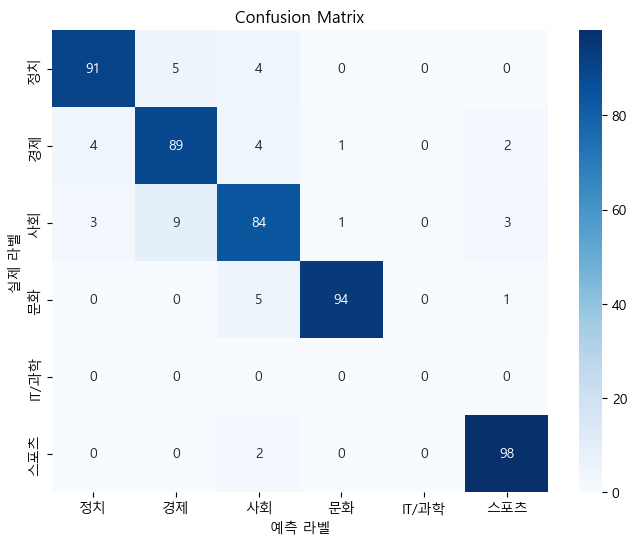

              precision    recall  f1-score   support

          정치       0.93      0.91      0.92       100
          경제       0.86      0.89      0.88       100
          사회       0.85      0.84      0.84       100
          문화       0.98      0.94      0.96       100
       IT/과학       0.00      0.00      0.00         0
         스포츠       0.94      0.98      0.96       100

    accuracy                           0.91       500
   macro avg       0.76      0.76      0.76       500
weighted avg       0.91      0.91      0.91       500



In [ ]:
# 9. Confusion Matrix & Classification Report

# 클래스별 Precision/Recall/F1 점수 시각화 - 모델이 어떤 클래스에서 강하고 약한지 확인
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 테스트셋 전체 예측
# test_texts = tokenized_dataset['test']['input_ids']
# test_labels = tokenized_dataset['test']['labels']
test_loader = DataLoader(tokenized_dataset['test'], batch_size=16)

all_preds = []
all_labels = []

# 모델 추론
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy() # cpu로 변환

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3,4,5])
label_names = ["정치", "경제", "사회", "문화", "IT/과학", "스포츠"]

plt.rc('font', family='Malgun Gothic')   # ✅ 한글 폰트 지정
plt.rc('axes', unicode_minus=False)      # ✅ 마이너스 기호 깨짐 방지
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('예측 라벨')
plt.ylabel('실제 라벨')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (모든 클래스 강제 포함)
print(classification_report(all_labels, all_preds, labels=[0,1,2,3,4,5], target_names=label_names, zero_division=0))

In [39]:
# 10. 모델 저장
model.save_pretrained("./results_news_analysis_aihub_news")
tokenizer.save_pretrained("./results_news_analysis_aihub_news")

('./results_news_analysis_aihub_news\\tokenizer_config.json',
 './results_news_analysis_aihub_news\\special_tokens_map.json',
 './results_news_analysis_aihub_news\\sentencepiece.bpe.model',
 './results_news_analysis_aihub_news\\added_tokens.json',
 './results_news_analysis_aihub_news\\tokenizer.json')

In [40]:
# 11. 학습된 모델 로드
model = AutoModelForSequenceClassification.from_pretrained('./results_news_analysis_aihub_news')
tokenizer = AutoTokenizer.from_pretrained('./results_news_analysis_aihub_news')

In [41]:
# 12. 배치 추론 예시
texts = [
    "국회, 새로운 법안 통과 발표",             # 정치
    "삼성, 반도체 투자 확대 발표",             # 경제
    "서울 도심 집회에서 시민들 목소리 전달",     # 사회
    "뮤지컬 공연, 관객들 큰 호응",             # 문화
    "AI 기술 발전으로 의료 혁신 가속화",        # IT/과학
    "손흥민, 프리미어리그에서 멀티골 기록",      # 스포츠
    "정부, 경제 성장률 둔화 대응책 마련",        # 경제
    "김연아, 국제 피겨 대회에서 금메달 획득",    # 스포츠
    "구글, 인공지능 기반 번역 서비스 개선 발표", # IT/과학
    "전통 문화 축제, 지역 사회 활기"            # 문화
]

# 입력을 토크나이저로 변환 후 GPU로 이동
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True).to(device)

# 추론
with torch.no_grad():
    outputs = model(**inputs)

# 예측 결과
pred_ids = outputs.logits.argmax(dim=1).tolist()

# 카테고리 매핑 (AI Hub 뉴스 라벨 기준)
id2label = {
    0: "정치",
    1: "경제",
    2: "사회",
    3: "문화",
    4: "IT/과학",
    5: "스포츠"
}

for text, pred_id in zip(texts, pred_ids):
    print(f"문장: {text}")
    print(f"예측 카테고리: {id2label[pred_id]}")
    print("-" * 40)


문장: 국회, 새로운 법안 통과 발표
예측 카테고리: 정치
----------------------------------------
문장: 삼성, 반도체 투자 확대 발표
예측 카테고리: 경제
----------------------------------------
문장: 서울 도심 집회에서 시민들 목소리 전달
예측 카테고리: 사회
----------------------------------------
문장: 뮤지컬 공연, 관객들 큰 호응
예측 카테고리: 문화
----------------------------------------
문장: AI 기술 발전으로 의료 혁신 가속화
예측 카테고리: 경제
----------------------------------------
문장: 손흥민, 프리미어리그에서 멀티골 기록
예측 카테고리: 스포츠
----------------------------------------
문장: 정부, 경제 성장률 둔화 대응책 마련
예측 카테고리: 경제
----------------------------------------
문장: 김연아, 국제 피겨 대회에서 금메달 획득
예측 카테고리: 스포츠
----------------------------------------
문장: 구글, 인공지능 기반 번역 서비스 개선 발표
예측 카테고리: 경제
----------------------------------------
문장: 전통 문화 축제, 지역 사회 활기
예측 카테고리: 문화
----------------------------------------
